<a href="https://colab.research.google.com/github/mohitjain26/Age-and-Gender-Estimation/blob/master/NLP_DuplicateDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Accessing Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install plotly
!pip install distance
!pip install fuzzywuzzy
!pip install wordcloud

Importing Libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import distance
from bs4 import BeautifulSoup 
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
import math
import re
# This package is used for finding longest common subsequence between two strings
from nltk.corpus import wordnet
from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.stem import PorterStemmer

In [ ]:
#import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/Thesis/train.csv")
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


# Data Understanding

1 Checking for removing NULL values data points 


In [ ]:
train_data.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
#printing indices of points which contain null values
nullIndices = []
for index, textinfo in train_data.iterrows():
    if type(textinfo["question1"]) is not str or type(textinfo["question2"]) is not str:
        print(index)
        nullIndices.append(index)

105780
201841
363362


In [ ]:
train_data.drop(nullIndices, axis = 0, inplace = True)
train_data.isnull().sum()


id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

2 Checking label counts and balancing the data


In [ ]:
label_name = train_data['is_duplicate'].map({0:"Not-Duplicate", 1:"Duplicate"})
label_name.value_counts()

Not-Duplicate    255024
Duplicate        149263
Name: is_duplicate, dtype: int64

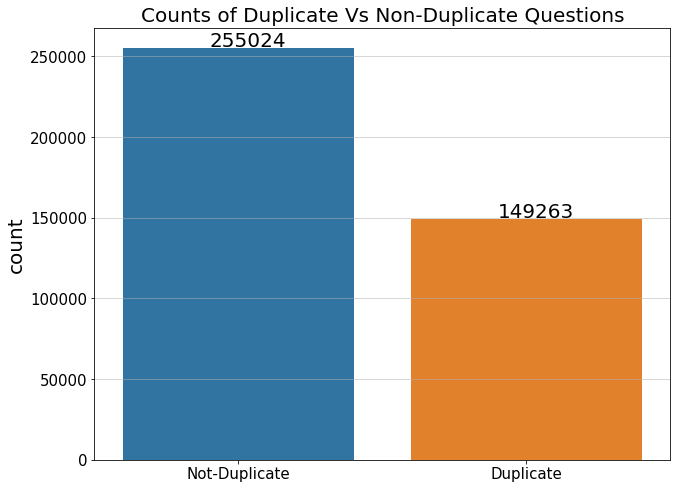

In [ ]:
fig = plt.figure(figsize = (8, 6))
axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Counts of Duplicate Vs Non-Duplicate Questions", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
plt.grid(linestyle='-', linewidth=0.5)
axes.tick_params(labelsize = 15)
sns.countplot(list(label_name), ax = axes)
for i in axes.patches:
    axes.text(i.get_x()+0.3, i.get_height()+1000, str(round(i.get_height(), 2)), fontsize=20, color='black')
plt.show()

Number of data-points which contains non-duplicate questions are very high as compared to data-points which contains duplicate questions. Since we already have enough number of data-points so we have decided that we will remove 105700 non-duplicate data-points from our data so that the difference between duplicate and non-duplicate questions will be minimal.

In [ ]:
# Balancing the data
train_data_nonDup = train_data[train_data['is_duplicate'] == 0]
train_data_Dup = train_data[train_data['is_duplicate'] == 1]
totalFrame = [train_data_nonDup.sample(train_data_nonDup.shape[0]-105700), train_data_Dup]
data_new = pd.concat(totalFrame)
data_new.sort_values('id', axis=0, ascending=True, inplace=True)
data_new.reset_index(drop = True, inplace = True)
data_new.head()


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


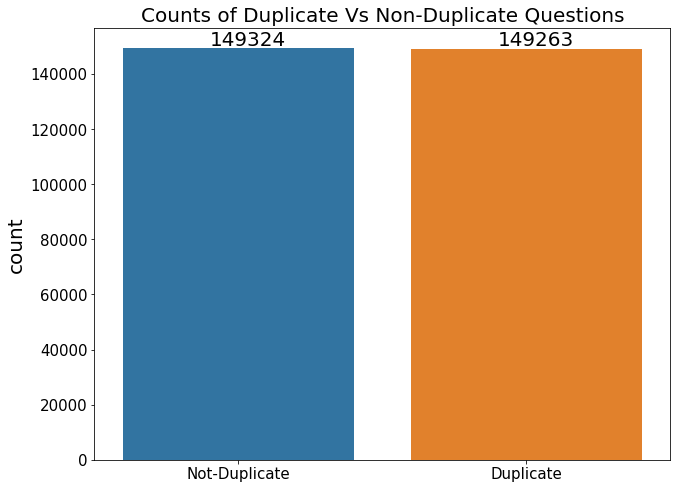

In [ ]:
label_name = data_new['is_duplicate'].map({0:"Not-Duplicate", 1:"Duplicate"})
fig = plt.figure(figsize = (8, 6))
axes = fig.add_axes([0.1,0.1,1,1])
axes.set_title("Counts of Duplicate Vs Non-Duplicate Questions", fontsize = 20)
axes.set_ylabel("Count", fontsize = 20)
axes.tick_params(labelsize = 15)
sns.countplot(list(label_name), ax = axes)
for i in axes.patches:
    axes.text(i.get_x()+0.3, i.get_height()+1000, str(round(i.get_height(), 2)), fontsize=20, color='black')
plt.show()

In [ ]:
data_new['is_duplicate'].value_counts()


0    149324
1    149263
Name: is_duplicate, dtype: int64

3 Number of Unique Questions

In [ ]:
# Filtered Dataset
data_new['is_duplicate'].value_counts()


0    149324
1    149263
Name: is_duplicate, dtype: int64

In [ ]:
total_ques = pd.Series(data_new['qid1'].tolist() + data_new['qid2'].tolist()) #here, by addition all of the elements of
#both the arrays will merge into one big array. So, now 'total_ques' contains ids of both 'qid1' and 'qid2' in one big array.
unique_ques = len(np.unique(total_ques))
non_unique_ques = np.sum(total_ques.value_counts()>1) #now, the value_counts() have the values greater than one for all those 
#elements who are occurring more than one. So, this give give us the count of all the number of repeated questions.
print("Total number of unique questions = "+str(unique_ques))
print("Total number of unique questions that appeared more than one time = "+str(non_unique_ques))
print("Question which appeared most number of times = "+str(max(total_ques.value_counts())))

Total number of unique questions = 390952
Total number of unique questions that appeared more than one time = 79115
Question which appeared most number of times = 107


4 Checking for Duplicates

In [ ]:
data_duplicates = data_new[['qid1','qid2', 'question1','question2','is_duplicate']].groupby(['qid1', 'qid2']).count()
print("Numbr of duplicate entries = "+str(data_new.shape[0] - data_duplicates.shape[0]))

Numbr of duplicate entries = 0


In [ ]:
# Download of Lexical Database
import nltk
nltk.download('stopwords')
nltk.download('brown')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Tanvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\Tanvi\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Tanvi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Data Preprocessing 

In [ ]:
# preprocessing the data
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
                   

    return x

In [ ]:
#preprocessed data
data_new["question1"] = data_new["question1"].fillna("").apply(preprocess)
data_new["question2"] = data_new["question2"].fillna("").apply(preprocess)

In [ ]:
data_new

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0
...,...,...,...,...,...,...,...
298582,298582,404280,537922,537923,what are some outfit ideas to wear to a frat p...,what are some outfit ideas wear to a frat them...,1
298583,298583,404281,99131,81495,why is manaphy childish in pokémon ranger and ...,why is manaphy annoying in pokemon ranger and ...,1
298584,298584,404282,1931,16773,how does a long distance relationship work,how are long distance relationships maintained,1
298585,298585,404284,537926,537927,what does jainism say about homosexuality,what does jainism say about gays and homosexua...,1


# Feature Extraction
1. Implementing Semantic Similarity using brown and wordnet database


In [ ]:
freq = FreqDist(brown.words())
log_words = math.log(len(brown.words()) + 1)

#This function is used to calculate the similarity between two words
#It takes a word, sentence vector and value as input parameters
#It returna a list indicating similarity and index of word matched
def similarity(term, sc1, factor):
    # try:
        if sc1 == [] or sc1 == None:
            return [0, None]
        sim_list = []
        for a in sc1:
            v1 = wordnet.synsets(term)
            v2 = wordnet.synsets(a)
            if v1 == [] or v2 == []:
                return [0, None]
            else:
                v1 = v1[0]
                v2 = v2[0]
            if v1.path_similarity(v2) != None:
                sim_list.append(v1.path_similarity(v2) * v1.wup_similarity(v2))
            else:
                sim_list.append(0)
        if max(sim_list) >= factor:
            return [max(sim_list), sim_list.index(max(sim_list))]
        else:
            return [0, None]
    # except:
        #print(sc1)

#This method is used to compute semantic vector of a given sentence
#It takes sentence vector and jointset as input parameters
#It returns a semantic vector of a sentence

def similarityVector(sc1, joinset):
    vector = []
    identity = 0
    #print("similarityVector: ", sc1, joinset)
    for term in joinset:
        identity = 1 - (math.log(freq[term] + 1)/log_words)
        if term in sc1:
            vector.append(1 * identity * identity)
        else:
            sim, termPos = similarity(term,sc1, 0.2)
            if termPos == None:
                identity = 0
            else:
                identity = identity * (1 - (math.log(freq[sc1[termPos]] + 1)/log_words))
            vector.append(sim * identity)
   # print('VEC: ',vector)
    return vector

#This method measures the cosine similarity between two vectors
#This method takes semantic vector of two sentences as input parameters
#It returns a value between 0 and 1
def cosineSimilarity(v1,v2):
    mod_v1 = 0
    mod_v2 = 0
    cos = 0
    dot_product = 0
    # print('v1: ', v1)
    # print('v2: ', v2)
    for i in range(len(v2)):
        mod_v1 = mod_v1 + v1[i]*v1[i]
        mod_v2 = mod_v2 + v2[i]*v2[i]
        dot_product = dot_product + v1[i]*v2[i]
        if mod_v1 == 0 or mod_v2 == 0:
            return 0 
        cos = float(dot_product)/float((mod_v1*mod_v2)**0.5)   
    return cos

#This function determines the Word order vector of a sentence
#It takes sentence vector and joint set as input parameters    
#It returns an order vector for sentence
def orderVector(sc1, joinset):
    vector = []
    indexPos = None
    for term in joinset:
        if term in sc1:
            vector.append(sc1.index(term))
        else:
            indexPos = similarity(term, sc1, 0.4)[1]
            if indexPos == None:
                vector.append(0)
            else:
                vector.append(indexPos)
    return vector

#This method measures order similarity between two vectors
#This method takes order vector of two sentences as input parameters
#It returns a value between 0 and 1
def orderSimilarity(v1, v2):
    mod1 = 0
    mod2 = 1
    for i in range(len(v1)):
        mod1 = mod1 + (v1[i] - v2[i]) * (v1[i] - v2[i])
        mod2 = mod2 + (v1[i] + v2[i]) * (v1[i] + v2[i])
    return 1 - math.sqrt(mod1/mod2)

#data INPUT   
dataset = data_new
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, 6].values
result = 0
count = 0
total = 0
semanticList = []
orderList = []
for k in range(0, len(Y)):
    total = total + 1
    # print(total)
    a1 = X[k][4].split()
    a2 = X[k][5].split()

    joinset = set()
    for i in range(len(a1)):
        a1[i] = a1[i].lower()
        joinset.add(a1[i])
    for i in range(len(a2)):
        a2[i] = a2[i].lower()
        joinset.add(a2[i])
    joinset = list(joinset)
    sem_vector1 = []
    sem_vector2 = []
    order_vector1 = []
    order_vector2 = []
    try:
        sem_vector1 = similarityVector(a1, joinset)
        sem_vector2 = similarityVector(a2, joinset)
        
        order_vector1 = orderVector(a1, joinset)
        order_vector2 = orderVector(a2, joinset)
    except e:
      #print("in except", e)
      #print(a1)
      #print(a2)
      #print(k)
      # print(sem_vector1)
      # print(sem_vector2)
      pass
            
    #print(joinset)
    #print(sem_vector1)
    #print(sem_vector2)
    #print(order_vector1)
    #print(order_vector2)

    semantic = cosineSimilarity(sem_vector1, sem_vector2)
    order = orderSimilarity(order_vector1, order_vector2)
    semanticList.append(semantic)
    orderList.append(order)
    #print('semantic',semantic)
    #print(order)
    delta = 0.85
    similarity_final = delta * semantic + order * (1 - delta)   
    #print('similarity:'+ str(similarity_final))
    if similarity_final >= 0.75:
        result = 1
    else:
        result = 0
    if result == Y[k]:
        count = count + 1

#print("The Accuracy of this model is:",count/404289)


**In summary, similarity between words is determined not only by path lengths but also by depth.**

In [ ]:
data_new['Cosine_Sim'] = semanticList
data_new['Order_Sim'] = orderList
data_new.head()

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,Cosine_Sim,Order_Sim
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.786447,0.715911
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.806139,0.541225
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.000000,0.056788
3,3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000760
4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.000000,0.176834


**Conclusion: From this Project, we came to know that the Similarity Metrics used for calculating Document Similarity cannot be applied to compute Short Text Sentence Similarity. For this, we have to predict the similarity something nearer to Human Intuition. We made efforts to achieve something nearer to human intuition, in this project.


2. Implementing fuzzy wuzzy for feature extraction

In [ ]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions  
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(train_data):
    # preprocessing each question
    train_data["question1"] = train_data["question1"].fillna("").apply(preprocess)
    train_data["question2"] = train_data["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = train_data.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    train_data["cwc_min"]       = list(map(lambda x: x[0], token_features))
    train_data["cwc_max"]       = list(map(lambda x: x[1], token_features))
    train_data["csc_min"]       = list(map(lambda x: x[2], token_features))
    train_data["csc_max"]       = list(map(lambda x: x[3], token_features))
    train_data["ctc_min"]       = list(map(lambda x: x[4], token_features))
    train_data["ctc_max"]       = list(map(lambda x: x[5], token_features))
    train_data["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    train_data["first_word_eq"] = list(map(lambda x: x[7], token_features))
    train_data["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    train_data["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    print("fuzzy features..")

    train_data["token_set_ratio"]       = train_data.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    train_data["token_sort_ratio"]      = train_data.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    train_data["fuzz_ratio"]            = train_data.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    train_data["fuzz_partial_ratio"]    = train_data.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    train_data["longest_substr_ratio"]  = train_data.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return train_data

In [ ]:
fuzzy_data = extract_features(data_new)

token features...
fuzzy features..


In [ ]:
fuzzy_data

,Unnamed: 0,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,...,0.307690,0.0,1.0,6.0,10.0,67,47,35,56,0.175000
4,4,5,11,12,astrology i am a capricorn sun cap moon and c...,i am a triple capricorn sun moon and ascenda...,1,0.666656,0.571420,0.888879,...,0.705878,1.0,0.0,0.0,17.0,81,77,73,73,0.160920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298585,298585,404282,1931,16773,how does a long distance relationship work,how are long distance relationships maintained,1,0.499988,0.499988,0.499975,...,0.428565,0.0,1.0,1.0,6.5,77,73,75,77,0.613636
298586,298586,404284,537926,537927,what does jainism say about homosexuality,what does jainism say about gays and homosexua...,1,0.999967,0.749981,0.999967,...,0.749991,1.0,1.0,2.0,7.0,100,90,90,79,0.651163
298587,298587,404286,18840,155606,do you believe there is life after death,is it true that there is life after death,1,0.666644,0.666644,0.599988,...,0.555549,1.0,0.0,1.0,8.5,79,69,72,76,0.642857
298588,298588,404287,537928,537929,what is one coin,what is this coin,0,0.999900,0.499975,0.999950,...,0.749981,1.0,1.0,0.0,4.0,86,79,79,76,0.444444


Visualization of Fuzzy features

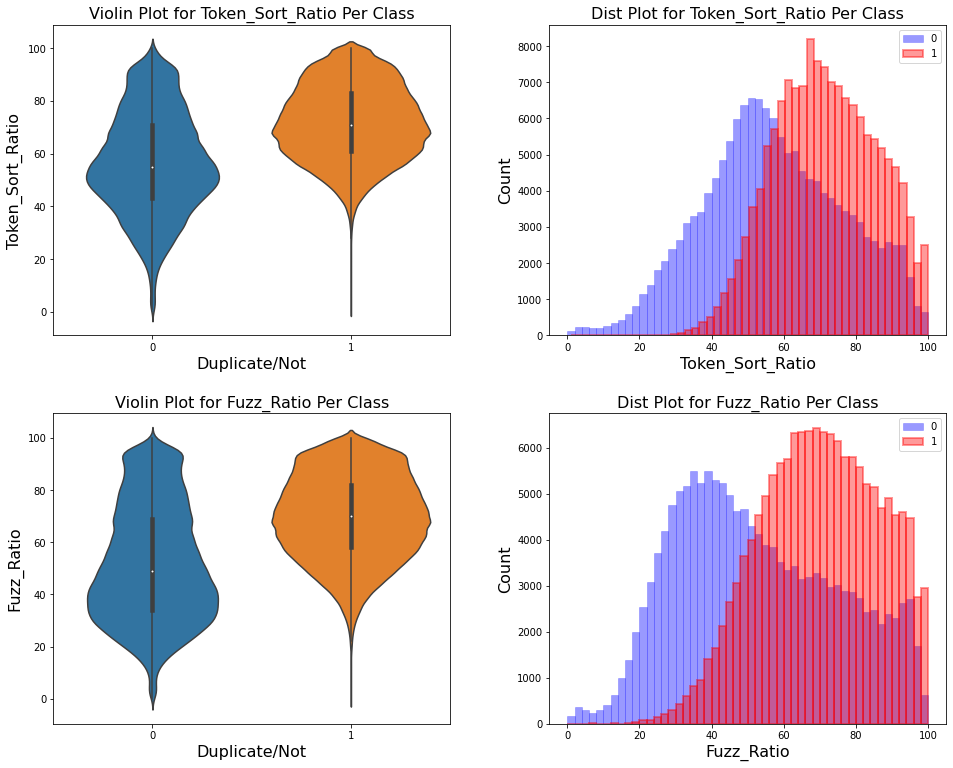

In [ ]:
plt.figure(figsize=(16, 20))

plt.subplot(3,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = fuzzy_data)
plt.title("Violin Plot for Token_Sort_Ratio Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Token_Sort_Ratio", fontsize = 16)

plt.subplot(3,2,2)
sns.distplot(fuzzy_data[fuzzy_data['is_duplicate'] == 0]['token_sort_ratio'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="b", linewidth=0.5))
sns.distplot(fuzzy_data[fuzzy_data['is_duplicate'] == 1]['token_sort_ratio'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Token_Sort_Ratio Per Class", fontsize = 16)
plt.xlabel("Token_Sort_Ratio", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplot(3,2,3)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = fuzzy_data)
plt.title("Violin Plot for Fuzz_Ratio Per Class", fontsize = 16)
plt.xlabel("Duplicate/Not", fontsize = 16)
plt.ylabel("Fuzz_Ratio", fontsize = 16)

plt.subplot(3,2,4)
sns.distplot(fuzzy_data[fuzzy_data['is_duplicate'] == 0]['fuzz_ratio'], kde = False, color = 'blue', label = '0', hist_kws=dict(edgecolor="b", linewidth=0.5))
sns.distplot(fuzzy_data[fuzzy_data['is_duplicate'] == 1]['fuzz_ratio'], kde = False, color = 'red', label = '1', hist_kws=dict(edgecolor="r", linewidth=2))
plt.title("Dist Plot for Fuzz_Ratio Per Class", fontsize = 16)
plt.xlabel("Fuzz_Ratio", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend()

plt.subplots_adjust(hspace = 0.25, wspace = 0.25)
plt.show()

Combining both semantic and fuzzy features.


In [ ]:
# merging fuzzy features into previous dataframe (in which semantic similarity is present)

temp = fuzzy_data[['token_set_ratio','token_sort_ratio','fuzz_ratio','fuzz_partial_ratio','longest_substr_ratio']]
data_new = data_new.join(temp)


In [ ]:
data_new.head()

,Unnamed: 0,Unnamed: 0.1,id,qid1,qid2,question1,question2,is_duplicate,Cosine_Sim,Order_Sim,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.786447,0.715911,100,93,93,100,0.982759
1,1,1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.806139,0.541225,86,63,66,75,0.596154
2,2,2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.000000,0.056788,63,63,43,47,0.166667
3,3,3,3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000760,67,47,35,56,0.175000
4,4,4,4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.000000,0.176834,81,77,73,73,0.160920


In [ ]:
# removing unwanted columns
del data_new['Unnamed: 0.1']
del data_new['id']

In [ ]:
data_new.head()

,qid1,qid2,question1,question2,is_duplicate,Cosine_Sim,Order_Sim,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.786447,0.715911,100,93,93,100,0.982759
1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.806139,0.541225,86,63,66,75,0.596154
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.000000,0.056788,63,63,43,47,0.166667
3,7,8,why am i mentally very lonely how can i solve...,find the remainder when math 23 24 math i...,0,0.000000,0.000760,67,47,35,56,0.175000
4,9,10,which one dissolve in water quikly sugar salt...,which fish would survive in salt water,0,0.000000,0.176834,81,77,73,73,0.160920


In [ ]:
!pip install mlxtend

In [ ]:
# Using scikit learn for training and evaluation
from sklearn.datasets import make_blobs
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from mlxtend.plotting import plot_decision_regions

# Generate data
X = data_new.iloc[:,6:13] 
y = data_new.iloc[:,5]


# Split into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [ ]:
X_train


,Cosine_Sim,Order_Sim,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
179646,0.000000,0.457135,80,63,66,70,0.315789
106795,0.000000,0.579635,80,54,51,79,0.400000
184117,0.000000,0.002736,52,48,56,64,0.288889
200384,0.000000,0.262597,100,93,93,100,0.986111
91572,0.040300,0.086312,98,94,96,92,0.462687
...,...,...,...,...,...,...,...
119879,0.000000,0.000086,90,69,69,87,0.615385
259178,0.000000,0.406801,84,77,84,83,0.428571
131932,0.754781,0.558133,100,90,90,93,0.914894
146867,0.719692,0.265582,81,72,72,81,0.729730


In [ ]:
y_train

179646    1
106795    0
184117    0
200384    0
91572     0
         ..
119879    0
259178    0
131932    1
146867    1
121958    0
Name: is_duplicate, Length: 200053, dtype: int64

In [ ]:
# rescaling train dataset
from sklearn import preprocessing
from sklearn import svm, datasets

X_train = preprocessing.scale(X_train)
#rescaling test dataset
X_test = preprocessing.scale(X_test)


# Modelling and Evaluation Using SVM 

Below several cases has been performed to optimized the SVM classfier by changing the value of C and gamma

#CASE 1
C= 10, gamma=0.01

In [ ]:
# hyperparameter tuning manual
# Create the SVM
svm1 = SVC(C=10,gamma=0.01, kernel='rbf')


In [ ]:
# Fit the data to the SVM classifier
svm1 = svm1.fit(X_train, y_train)
svm1

SVC(C=10, gamma=0.01)

In [ ]:
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from mlxtend.plotting import plot_decision_regions
from sklearn.metrics import classification_report


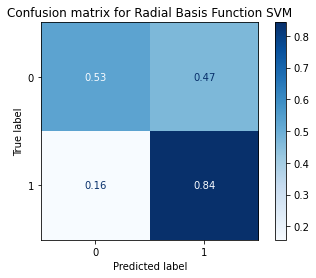

In [ ]:
# Evaluate by means of a confusion matrix
matrix = plot_confusion_matrix(svm1, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for Radial Basis Function SVM')
plt.show(matrix)
plt.show()


In [ ]:
# Generate predictions
y_pred1 = svm1.predict(X_test)

print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.77      0.53      0.63     49119
           1       0.64      0.84      0.73     49415

    accuracy                           0.69     98534
   macro avg       0.71      0.69      0.68     98534
weighted avg       0.71      0.69      0.68     98534



#CASE 2
c=100, gamma=0.001

In [ ]:
# Create the SVM
svm2 = SVC(C=100,gamma=0.001, kernel='rbf')

# Fit the data to the SVM classifier
svm2 = svm2.fit(X_train, y_train)


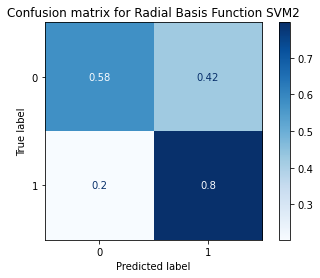

In [ ]:

# Evaluate by means of a confusion matrix
matrix = plot_confusion_matrix(svm2, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for Radial Basis Function SVM2')
plt.show(matrix)
plt.show()


In [ ]:
# Generate predictions
y_pred2 = svm2.predict(X_test)

print(classification_report(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.74      0.58      0.65     49119
           1       0.66      0.80      0.72     49415

    accuracy                           0.69     98534
   macro avg       0.70      0.69      0.68     98534
weighted avg       0.70      0.69      0.68     98534



#CASE 3
c=10, gamma=0.05

In [ ]:
#ANOTHER CASE OF HYPERTUNING
svm_case3 = SVC(C=10,gamma=0.05, kernel='rbf')

# Fit the data to the SVM classifier
svm_case3 = svm_case3.fit(X_train, y_train)

In [ ]:
svm_case3

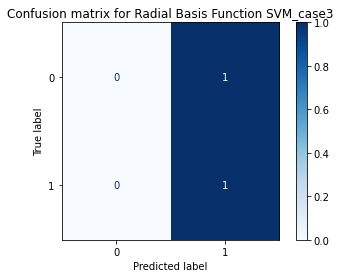

In [ ]:
# Evaluate by means of a confusion matrix
matrix = plot_confusion_matrix(svm_case3, X_test, y_test,
                                 cmap=plt.cm.Blues,
                                 normalize='true')
plt.title('Confusion matrix for Radial Basis Function SVM_case3')
plt.show(matrix)
plt.show()


In case-3, the value gamma is large because of that the effect of C become negligible. Very large gamma values result in too specific class regions (overfitting).